In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('./src/')
from plot_scores import plot_scores

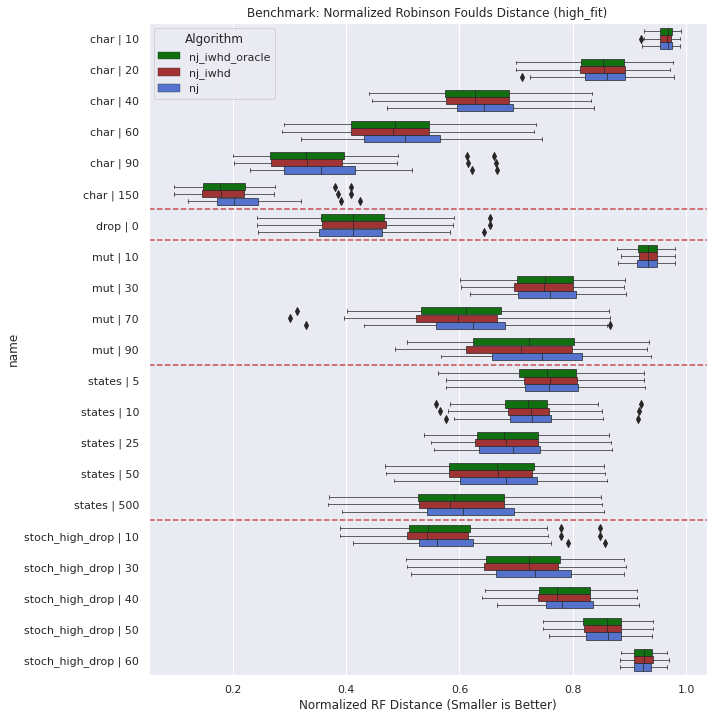

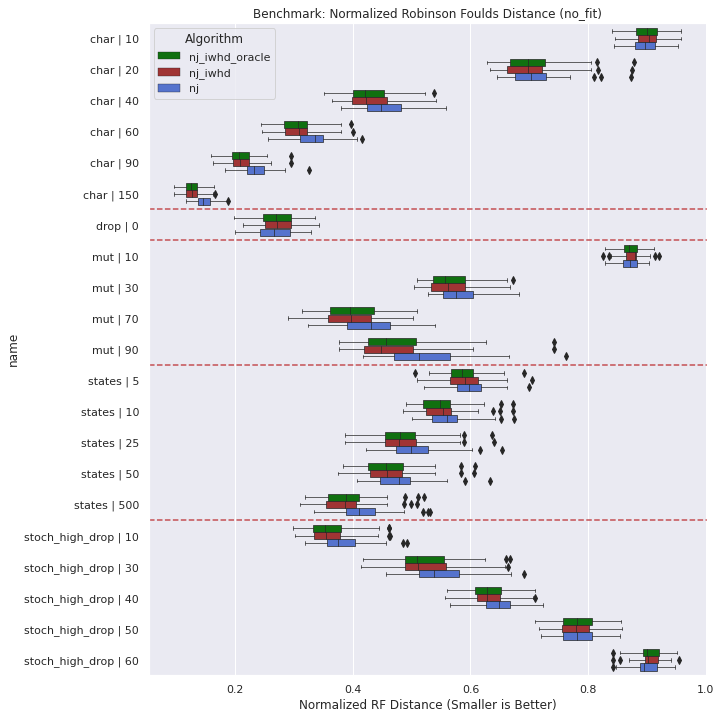

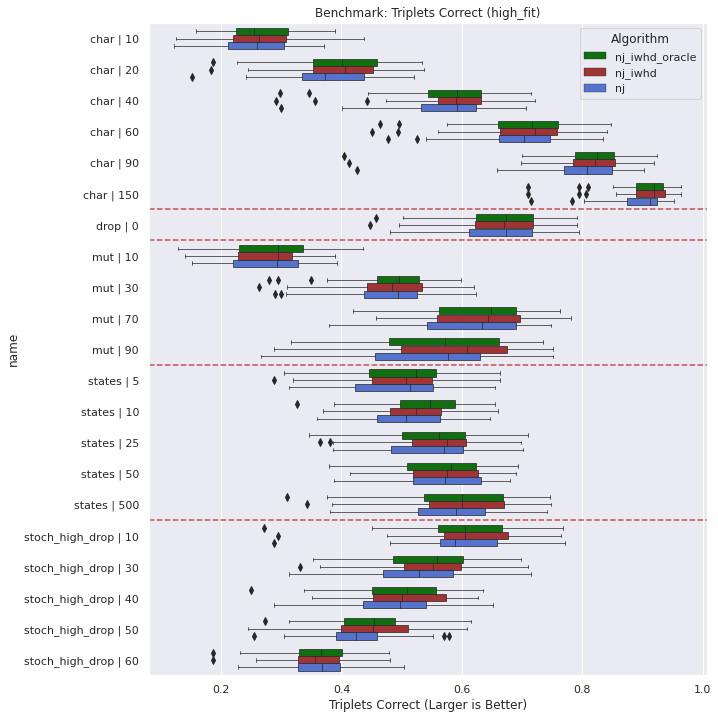

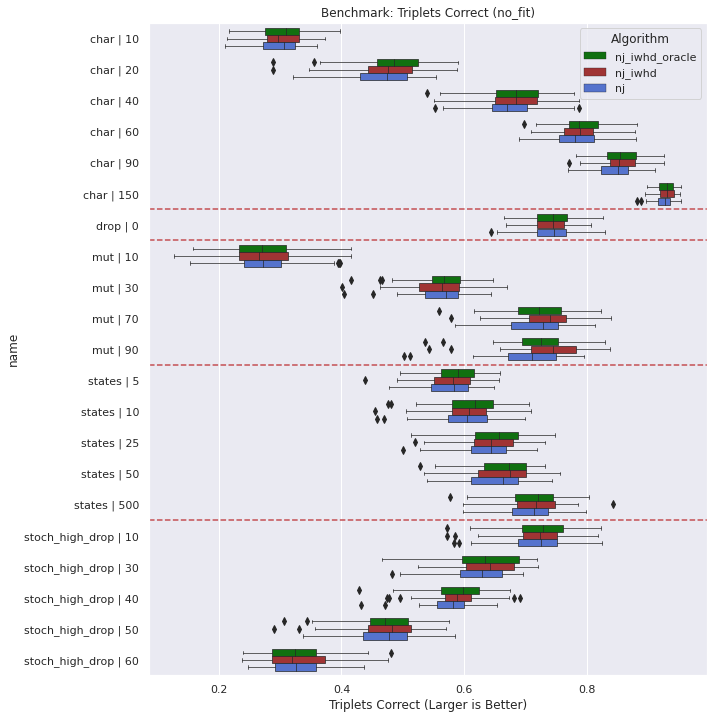

['plots/rf_benchmark.high_fit.png',
 'plots/rf_benchmark.no_fit.png',
 'plots/triplets_benchmark.high_fit.png',
 'plots/triplets_benchmark.no_fit.png']

In [27]:
# Plotting and splitting by Fitness
SCORES_DIR = "./data/scores/"

algs = [
    {
        "alg_name": "nj_iwhd_oracle",
        "box_color": "green",
        "scores_dir": SCORES_DIR
    },
    {
        "alg_name": "nj_iwhd",
        "box_color": "firebrick",
        "scores_dir": SCORES_DIR
    },
    {
        "alg_name": "nj",
        "box_color": "royalblue",
        "scores_dir": SCORES_DIR
    },
]

plot_scores(
    algs, 
    name_col_includes=[
        "Stressor",
        "Parameter"
    ],
    split_plots_by='Fitness'
    )

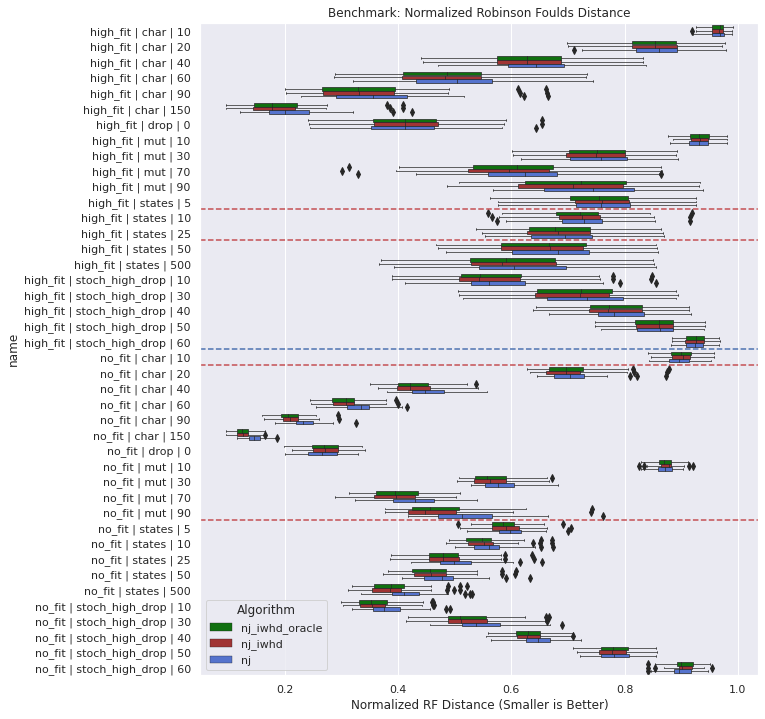

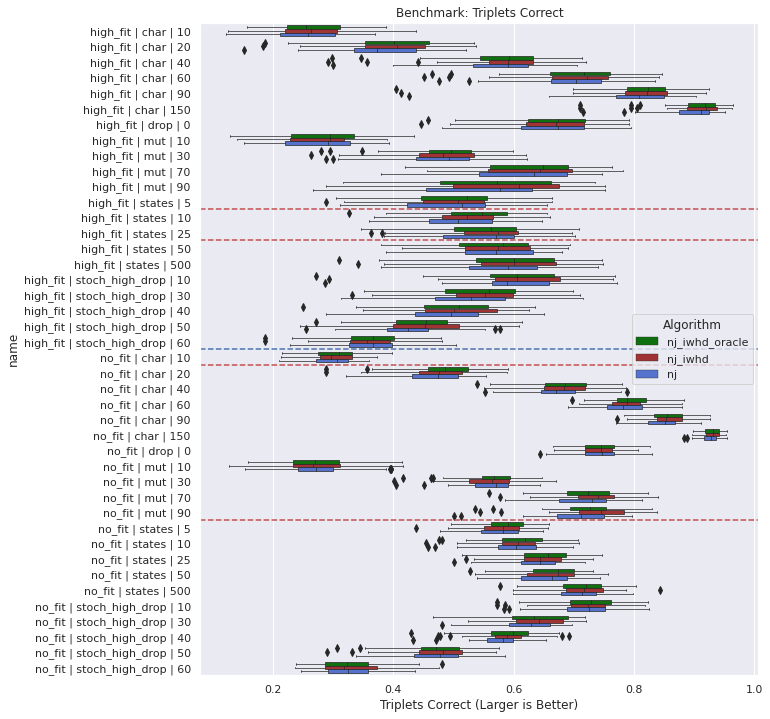

['plots/rf_benchmark.png', 'plots/triplets_benchmark.png']

In [29]:
# Plotting without splitting.
SCORES_DIR = "./data/scores/"

algs = [
    {
        "alg_name": "nj_iwhd_oracle",
        "box_color": "green",
        "scores_dir": SCORES_DIR
    },
    {
        "alg_name": "nj_iwhd",
        "box_color": "firebrick",
        "scores_dir": SCORES_DIR
    },
    {
        "alg_name": "nj",
        "box_color": "royalblue",
        "scores_dir": SCORES_DIR
    },
]

plot_scores(
    algs, 
    name_col_includes=[
        "Fitness",
        "Stressor",
        "Parameter"
    ],
    split_plots_by=None,
    )